In [9]:
from functools import partial
from time import time

import jax
import jax.numpy as jnp
from jax import grad, value_and_grad, vmap, jit, random
import equinox as eqx
import optax
import matplotlib.pyplot as plt

from playground_jax.models import *

We want to fit the following function $ f_\alpha: D \subset \mathbb{R}^2 \rightarrow \mathbb{R}$, $ f_\alpha(x_1, x_2) = \alpha \left({x_1}^2 + {x_2}^2 \right) $, $D = [-3, 3]^2$ 

In [21]:
def f(x1, x2, alpha=1.):
    return alpha * (x1**2 + x2**2)
    
#def f(x1, x2, alpha=1.):
#    return  alpha * jnp.sin(jnp.sqrt(x1**2 + x2**2))

1. Generate training data

In [22]:
def generate_data(f, N=101):
    
    # create grid
    x1 = x2 = jnp.linspace(-3, 3, N)
    grid_x1, grid_x2 = jnp.meshgrid(x1, x2, indexing='ij')
    x = jnp.stack((grid_x1, grid_x2))
    x = jnp.moveaxis(x, 0, -1)
    x_flat = jnp.reshape(x, (N*N, 2))
    
    # evaluate on grid
    y = f(grid_x1, grid_x2)
    y_flat = jnp.reshape(y, (N*N, 1))
    
    return x, y, x_flat, y_flat

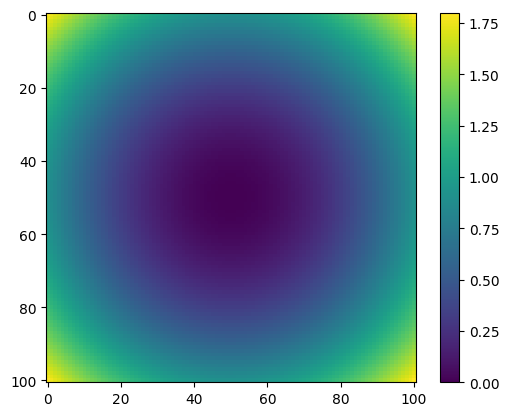

In [23]:
# set a random key
key = random.PRNGKey(1)

f_alpha = partial(f, alpha=1e-1)
N = 101
x, y, x_flat, y_flat = generate_data(f_alpha, N)

fig, ax = plt.subplots()
im = ax.imshow(y)
fig.colorbar(im)

2. Build a model

In [24]:
key, subkey = random.split(key)
model = FeedForwardNN(d_in=2, d_out=1, d_hidden=32, key=subkey)

3. Define optimization routine 

4. Define loss

In [29]:
@jit
def loss_fn(model, x, y):
    pred_y = vmap(model)(x)
    return jax.numpy.mean((y - pred_y) ** 2)

In [30]:
#@jit
def update_fn(model, x, y):
    loss, grads = value_and_grad(loss_fn)(model, x, y)
    model = jax.tree_map(lambda m, g: m - lr * g, model, grads)
    return loss

5. Train

In [31]:
batch_size = int(1e2)
lr = 1e-2
steps = int(1e4)
for i in range(steps):
    t0 = time()
    
    # sample data
    key, subkey = random.split(key)
    idx = random.randint(subkey, (batch_size,), 0, x_flat.shape[0])

    # update
    loss = update_fn(model, x_flat[idx], y_flat[idx])

    t1 = time()
    if i % int(1e3) == 0: 
        print('it: {:d}, loss: {:.3e}, time: {:.4f}s'.format(i, loss, t1-t0))

it: 0, loss: 8.016e-01, time: 0.0846s
it: 1000, loss: 7.662e-01, time: 0.0019s
it: 2000, loss: 8.426e-01, time: 0.0019s
it: 3000, loss: 7.073e-01, time: 0.0019s
it: 4000, loss: 7.731e-01, time: 0.0019s
it: 5000, loss: 6.795e-01, time: 0.0019s
it: 6000, loss: 8.553e-01, time: 0.0019s
it: 7000, loss: 8.068e-01, time: 0.0023s
it: 8000, loss: 6.848e-01, time: 0.0024s
it: 9000, loss: 8.138e-01, time: 0.0024s


6. Evaluate

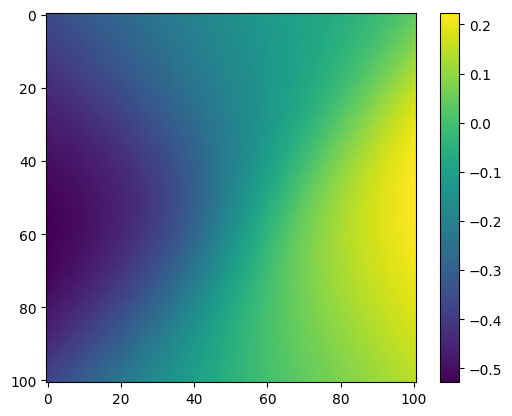

In [28]:
y_pred = vmap(model)(x_flat).reshape(y.shape)
fig, ax = plt.subplots()
im = ax.imshow(y_pred)
fig.colorbar(im)